In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from src.configspace import (
    COX_PH_CONFIGSPACE,
    GB_COX_CONFIGSPACE,
    GPR_CONFIGSPACE,
    POLY_RIDGE_CONFIGSPACE,
    RANDOM_FOREST_CONFIGSPACE,
    RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    RIDGE_CONFIGSPACE,
    SCHMEE_HAHN_QRF_CONFIGSPACE,
    SVR_CONFIGSPACE,
    TOBIT_NN_CONFIGSPACE,
    XGB_AFT_CONFIGSPACE,
    XGB_CONFIGSPACE,
)
from src.constant import (
    HO,
    PROCESSED_DATA_DIR,
    RANDOM_STATE_LIST,
    RESULTS_CONST_CUT_OFF_DIR,
    SOLVER_NUMBER_LIST,
)
from src.evaluation import evaluate_model_with_cross_validation
from src.hyperparameter_optimization import optimize_hyperparameters
from src.model import (
    SVR,
    CoxPHSurvivalAnalysis,
    GPRWithRBF,
    GradientBoostingSurvivalAnalysis,
    PolynomialRidge,
    RandomForestRegressor,
    RandomSurvivalForest,
    Ridge,
    SchmeeHahnQRF,
    TobitModel,
    XGBRegressor,
    XGBRegressorAFT,
)
from src.results import plot_line, plot_scatter, wilcoxon_df
from src.split import get_n_splits
from src.wrapper import (
    ScikitLearnWrapper,
    SkipCutOffScikitLearnWrapper,
    StandardScaledLogTransformedWrapper,
    SurvivalFunctionWrapper,
    XGBwrapper,
)

In [2]:
evaluations_df = pd.read_parquet(PROCESSED_DATA_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DATA_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DATA_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,0.95,1.0,0.0,0.0,0.2,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,0.15,0.0,1.0,1.0,0.4,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,0.20,0.0,1.0,2.0,0.9,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.60,1.0,1.0,2.0,0.7,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,0.90,1.0,1.0,3.0,0.3,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,0.45,0.0,0.0,0.0,0.2,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,0.20,1.0,0.0,3.0,0.6,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,0.95,1.0,1.0,3.0,0.9,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,0.65,0.0,0.0,1.0,0.5,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


In [3]:
CONST_CUT_OFF = 1

In [4]:
(df["cost"] >= CONST_CUT_OFF).value_counts(normalize=True)

True     0.67679
False    0.32321
Name: cost, dtype: float64

In [5]:
HO

namespace(N_TRIALS=500,
          N=3,
          INSTANCE_NUMBER=10,
          SOLVER_NUMBER=90,
          RANDOM_STATE=0)

In [6]:
SPLITS = get_n_splits(
    df=df,
    n=HO.N,
    instance_number=HO.INSTANCE_NUMBER,
    solver_number=HO.SOLVER_NUMBER,
    random_state=HO.RANDOM_STATE,
)

### Ridge

In [7]:
ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "ridge_incumbent.pkl",
)

ridge_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "ridge_incumbent_skip_cutoff.pkl",
)

### PolynomialRidge

In [8]:
poly_ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=PolynomialRidge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=POLY_RIDGE_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "poly_ridge_incumbent.pkl",
)

poly_ridge_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=PolynomialRidge,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=POLY_RIDGE_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "poly_ridge_incumbent_skip_cutoff.pkl",
)

### RandomForestRegressor

In [9]:
rf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomForestRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RANDOM_FOREST_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "rf_incumbent.pkl",
)

rf_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=RandomForestRegressor,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=RANDOM_FOREST_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "rf_incumbent_skip_cutoff.pkl",
)

### XGBRegressor

In [10]:
xgb_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=XGB_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "xgb_incumbent.pkl",
)

xgb_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressor,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=XGB_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "xgb_incumbent_skip_cutoff.pkl",
)

### SVR

In [11]:
svr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=SVR,
    wrapper_cls=ScikitLearnWrapper,
    configspace=SVR_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "svr_incumbent.pkl",
)

svr_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=SVR,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=SVR_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "svr_incumbent_skip_cutoff.pkl",
)

### GPRWithRBF

In [12]:
gpr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GPRWithRBF,
    wrapper_cls=ScikitLearnWrapper,
    configspace=GPR_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "gpr_incumbent.pkl",
)

gpr_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=GPRWithRBF,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=GPR_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "gpr_incumbent_skip_cutoff.pkl",
)

### CoxPHSurvivalAnalysis

In [13]:
coxph_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=CoxPHSurvivalAnalysis,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=COX_PH_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "coxph_incumbent.pkl",
)
coxph_incumbent

{'alpha': 16.6270761931804,
 'risk_function': 'par10',
 'ties': 'efron',
 'model_cls': sksurv.linear_model.coxph.CoxPHSurvivalAnalysis}

### RandomSurvivalForest

In [14]:
rsf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomSurvivalForest,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "rsf_incumbent.pkl",
)
rsf_incumbent

{'max_depth': 18,
 'max_features': 0.9569661465149,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_jobs': -1,
 'random_state': 0,
 'risk_function': 'par10',
 'model_cls': sksurv.ensemble.forest.RandomSurvivalForest}

### GradientBoostingSurvivalAnalysis

In [15]:
gb_cox_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GradientBoostingSurvivalAnalysis,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=GB_COX_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "gb_cox_incumbent.pkl",
)
gb_cox_incumbent

{'ccp_alpha': 0.0010141162662,
 'learning_rate': 0.0408766986133,
 'loss': 'coxph',
 'max_depth': 9,
 'max_features': 0.783730598812,
 'min_samples_leaf': 9,
 'min_samples_split': 3,
 'n_estimators': 778,
 'random_state': 0,
 'risk_function': 'par10',
 'subsample': 0.7720667371046,
 'model_cls': sksurv.ensemble.boosting.GradientBoostingSurvivalAnalysis}

### XGBRegressorAFT

In [16]:
xgb_aft_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressorAFT,
    wrapper_cls=XGBwrapper,
    configspace=XGB_AFT_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "xgb_aft_incumbent.pkl",
)
xgb_aft_incumbent

{'aft_loss_distribution': 'logistic',
 'colsample_bytree': 0.9297991817873,
 'eval_metric': 'aft-nloglik',
 'gamma': 1.4753684154123,
 'learning_rate': 0.0879371729785,
 'max_depth': 11,
 'min_child_weight': 1,
 'num_boost_round': 504,
 'objective': 'survival:aft',
 'reg_alpha': 0.0018147604226,
 'reg_lambda': 0.0027264311064,
 'seed': 0,
 'subsample': 0.7029603530202,
 'aft_loss_distribution_scale': 1.1531066300003,
 'model_cls': src.model.XGBRegressorAFT}

### SchmeeHahnQRF

In [17]:
sh_qrf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=SchmeeHahnQRF,
    wrapper_cls=StandardScaledLogTransformedWrapper,
    configspace=SCHMEE_HAHN_QRF_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "sh_qrf_incumbent.pkl",
)
sh_qrf_incumbent

{'ccp_alpha': 0.7533615819251,
 'ccp_alpha_rf': 0.0078264141709,
 'k': 10,
 'max_depth': 10,
 'max_depth_rf': 21,
 'max_features': 0.0951546486007,
 'max_features_rf': 0.991281227738,
 'min_samples_leaf': 16,
 'min_samples_leaf_rf': 1,
 'min_samples_split': 8,
 'min_samples_split_rf': 4,
 'n_jobs': -1,
 'random_state': 0,
 'model_cls': src.model.SchmeeHahnQRF}

### TobitModel

In [18]:
tobit_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=TobitModel,
    wrapper_cls=StandardScaledLogTransformedWrapper,
    configspace=TOBIT_NN_CONFIGSPACE,
    splits=SPLITS,
    const_cut_off=CONST_CUT_OFF,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_CONST_CUT_OFF_DIR / "HO" / "tobit_incumbent.pkl",
)
tobit_incumbent

{'base_lr': 0.0003439152773,
 'dropout': 0.2069859934518,
 'momentum': 0.274228936165,
 'n_epochs': 101,
 'scheduler_step_size_up': 91,
 'model_cls': src.model.TobitModel}

## Comparison

In [19]:
model_info_list = [
    # include cut-off
    {
        "wrapper": ScikitLearnWrapper(**ridge_incumbent),
        "name": "Ridge Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**poly_ridge_incumbent),
        "name": "Polynomial Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**svr_incumbent),
        "name": "Support Vector Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**gpr_incumbent),
        "name": "Gaussian Process Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**rf_incumbent),
        "name": "Random Forest"
    },
    {
        "wrapper": ScikitLearnWrapper(**xgb_incumbent),
        "name": "XGBoost"
    },
    # skip cut-off
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**ridge_incumbent_skip_cutoff),
        "name": "Ridge Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**poly_ridge_incumbent_skip_cutoff),
        "name": "Polynomial Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**svr_incumbent_skip_cutoff),
        "name": "Support Vector Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**gpr_incumbent_skip_cutoff),
        "name": "Gaussian Process Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**rf_incumbent_skip_cutoff),
        "name": "Random Forest (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**xgb_incumbent_skip_cutoff),
        "name": "XGBoost (skip cut-off)"
    },
    # survival models
    {
        "wrapper": SurvivalFunctionWrapper(**coxph_incumbent),
        "name": "Cox PH"
    },
    {
        "wrapper": SurvivalFunctionWrapper(**rsf_incumbent),
        "name": "Random Survival Forest"
    },
    {
        "wrapper": SurvivalFunctionWrapper(**gb_cox_incumbent),
        "name": "Gradient Boosting Cox"
    },
    {
        "wrapper": XGBwrapper(**xgb_aft_incumbent),
        "name": "XGBoost AFT"
    },
    {
        "wrapper": StandardScaledLogTransformedWrapper(**sh_qrf_incumbent),
        "name": "S&H QRF"
    },
    {
        "wrapper": StandardScaledLogTransformedWrapper(**tobit_incumbent),
        "name": "NN Tobit"
    },
]
 
# total_iterations = len(RANDOM_STATE_LIST) * len(SOLVER_NUMBER_LIST) * len(model_info_list)
# pbar = tqdm(total=total_iterations, desc="Evaluating models")

# records = []

# for random_state in RANDOM_STATE_LIST:
#     for solver_number in SOLVER_NUMBER_LIST:
#         pbar.set_description(f"RS={random_state}, Solvers={solver_number}")
#         splits = get_n_splits(
#             df,
#             n=5,
#             instance_number=10,
#             solver_number=solver_number,
#             random_state=random_state,
#         )
#         for model_info in model_info_list:
#             pbar.set_postfix(model=model_info["name"])

            # result = evaluate_model_with_cross_validation(
#                 df,
#                 wrapper=model_info["wrapper"],
#                 splits=splits,
#                 random_state=random_state,
#                 const_cut_off=CONST_CUT_OFF,
#             )
#             result["random_state"] = random_state
#             result["solver_number"] = solver_number
#             result["name"] = model_info["name"]
#             records.append(result)
#             pbar.update(1)

# pbar.close()
# result_df = pd.DataFrame(records)
# result_df.to_pickle(RESULTS_CONST_CUT_OFF_DIR / "results.gzip", compression="gzip")

result_df = pd.read_pickle(RESULTS_CONST_CUT_OFF_DIR / "results.gzip", compression="gzip")

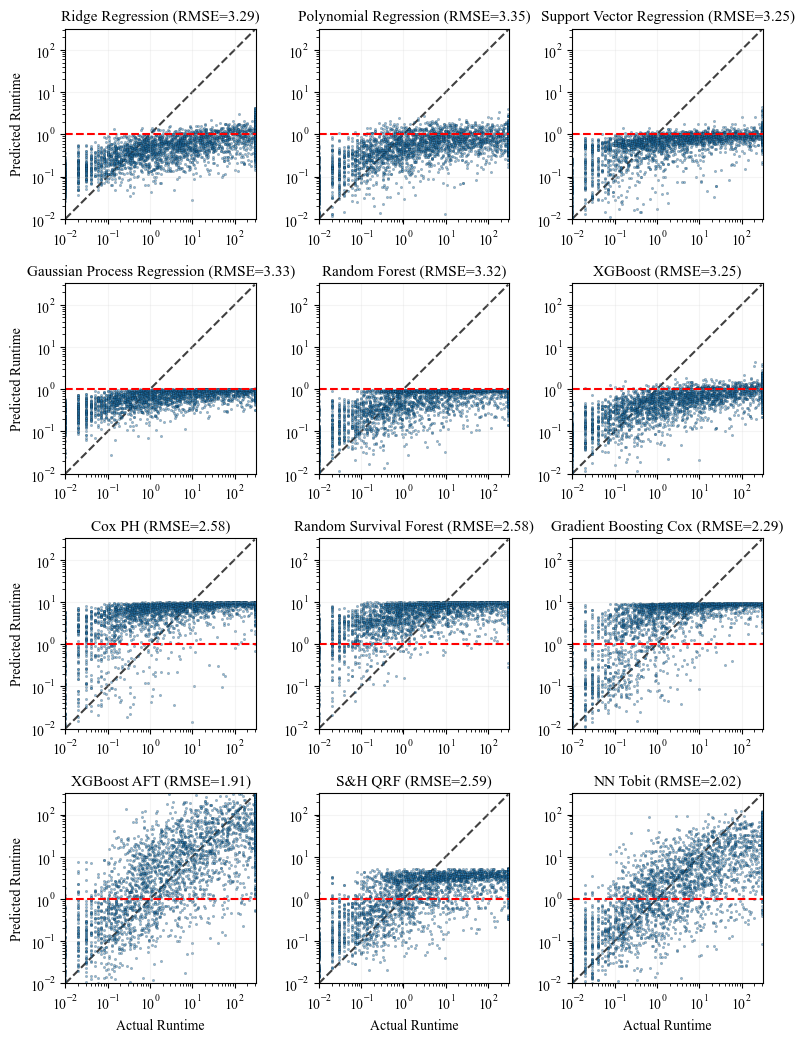

In [20]:
plot_df = result_df.loc[(result_df["random_state"] == 1) & (result_df["solver_number"] == 300)].iloc[[0, 1, 2, 3, 4, 5, 12, 13, 14, 15, 16, 17]].reset_index(drop=True)

fig, axs = plot_scatter(plot_df, const_cut_off=CONST_CUT_OFF)
# plt.savefig("fig.png", dpi=200, bbox_inches="tight")
plt.show()

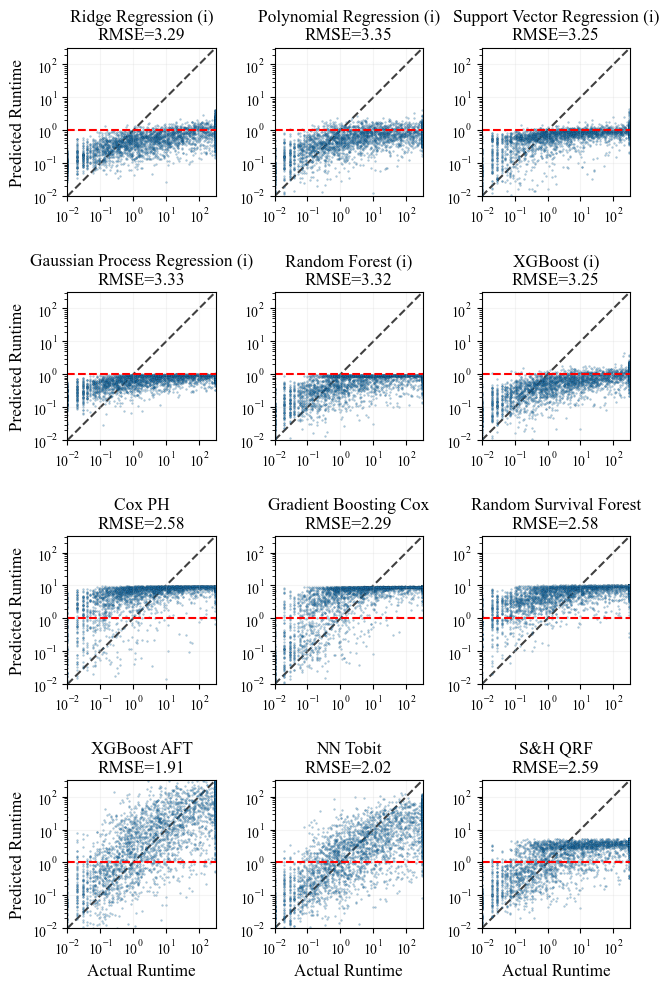

In [56]:
plot_df = result_df.loc[(result_df["random_state"] == 1) & (result_df["solver_number"] == 300)].iloc[[0, 1, 2, 3, 4, 5, 12,  14, 13, 15, 17, 16]].reset_index(drop=True)
plot_df.loc[:5, "name"] += " (i)"
const_cut_off = 1.0

n_plots = len(plot_df)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6.5, 2.5 * n_rows))

if n_rows == 1:
    axs = axs.reshape(1, -1)

axs = axs.flatten()

for i, result in plot_df.iterrows():
    ax = axs[i]

    ax.scatter(
        result["y_test_not_censored"],
        result["y_pred"],
        alpha=0.4,
        edgecolors="k",
        lw=0.1,
        s=2,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(0.01, 320)
    ax.set_ylim(0.01, 320)
    ax.set_xticks([0.01, 0.1, 1, 10, 100])
    ax.set_yticks([0.01, 0.1, 1, 10, 100])
    ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
    ax.set_title(f'{result["name"]}\nRMSE={result["rmse"]:.2f}', fontsize=12.5)
    if const_cut_off is not None:
        ax.axhline(y=const_cut_off, color="red", linestyle="--")

for i in range(n_plots, len(axs)):
    axs[i].set_visible(False)

for row in range(n_rows):
    left_idx = row * n_cols
    if left_idx < n_plots:
        axs[left_idx].set_ylabel("Predicted Runtime", fontsize=12.3)

bottom_row_start = (n_rows - 1) * n_cols
for col in range(n_cols):
    bottom_idx = bottom_row_start + col
    if bottom_idx < n_plots:
        axs[bottom_idx].set_xlabel("Actual Runtime", fontsize=12.3)

plt.tight_layout(h_pad=2, w_pad=1.66)
plt.savefig("const_cut_off_1_scatterplot.png", dpi=200, bbox_inches="tight")
plt.show()

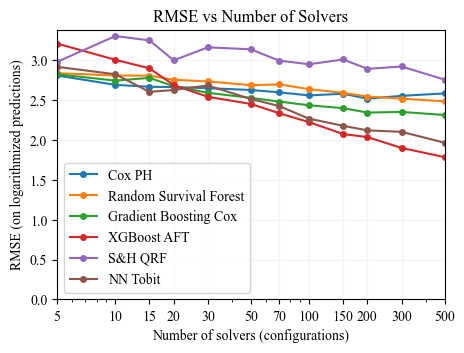

In [22]:
fig, ax = plot_line(
    result_df.loc[
        result_df["name"].isin(
            [
                "Cox PH",
                "Random Survival Forest",
                "Gradient Boosting Cox",
                "XGBoost AFT",
                "S&H QRF",
                "NN Tobit",
            ]
        )
    ]
)

# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

In [23]:
styled_result = wilcoxon_df(result_df, model_info_list)
styled_result

solver_number,5,10,15,20,30,50,70,100,150,200,300,500
name,,,,,,,,,,,,
Ridge Regression,3.272,3.552,3.359,3.300,4.064,3.539,3.394,3.441,3.472,3.407,3.490,3.404
Polynomial Regression,3.289,3.547,3.452,3.410,3.628,3.645,3.525,3.574,3.582,3.503,3.533,3.406
Support Vector Regression,3.264,3.499,3.365,3.301,3.502,3.515,3.387,3.426,3.449,3.378,3.451,3.355
Gaussian Process Regression,3.229,3.443,3.326,3.287,3.501,3.525,3.401,3.468,3.496,3.444,3.510,3.419
Random Forest,3.402,3.615,3.517,3.380,3.611,3.595,3.483,3.503,3.509,3.434,3.494,3.390
XGBoost,3.328,3.567,3.452,3.336,3.555,3.564,3.429,3.456,3.467,3.391,3.448,3.338
Ridge Regression (skip cut-off),3.787,3.831,3.564,3.558,3.794,3.926,3.628,3.644,3.682,3.576,3.696,3.610
Polynomial Regression (skip cut-off),4.384,4.564,4.281,4.001,4.335,4.283,4.079,4.050,3.977,3.808,3.752,3.442
Support Vector Regression (skip cut-off),3.830,3.836,3.734,3.635,3.872,3.860,3.898,3.941,4.138,4.146,4.446,4.726


In [24]:
idx = [x["name"] for x in model_info_list]
# fit time
result_df.pivot_table(index="name", columns="solver_number", values="fit_time", aggfunc="mean").loc[idx].style.background_gradient(cmap="coolwarm", axis=None).format(precision=2)

solver_number,5,10,15,20,30,50,70,100,150,200,300,500
name,,,,,,,,,,,,
Ridge Regression,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.01,0.01,0.01,0.01,0.02
Polynomial Regression,0.01,0.01,0.02,0.16,0.28,0.44,0.58,0.80,1.39,2.59,4.30,9.83
Support Vector Regression,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.02,0.04,0.07,0.14,0.40
Gaussian Process Regression,0.00,0.00,0.00,0.21,0.49,0.58,0.85,1.19,2.11,3.39,5.70,11.60
Random Forest,0.10,0.11,0.12,0.14,0.15,0.20,0.26,0.33,0.47,0.66,1.03,1.88
XGBoost,0.33,0.35,0.38,0.39,0.39,0.44,0.46,0.48,0.56,0.58,0.66,0.70
Ridge Regression (skip cut-off),0.05,0.06,0.06,0.07,0.05,0.07,0.05,0.09,0.09,0.09,0.08,0.10
Polynomial Regression (skip cut-off),0.07,0.09,0.10,0.12,0.13,0.14,0.31,0.38,0.45,0.63,0.87,1.97
Support Vector Regression (skip cut-off),0.04,0.04,0.02,0.01,0.00,0.00,0.01,0.01,0.01,0.01,0.02,0.07


In [33]:
# predict time
result_df.pivot_table(index="name", columns="solver_number", values="predict_time", aggfunc="mean").loc[idx].style.background_gradient(cmap="coolwarm", axis=None).format(precision=2)

solver_number,5,10,15,20,30,50,70,100,150,200,300,500
name,,,,,,,,,,,,
Ridge Regression,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Polynomial Regression,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.02
Support Vector Regression,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.02,0.05
Gaussian Process Regression,0.02,0.02,0.03,0.02,0.04,0.03,0.06,0.04,0.08,0.13,0.28,1.01
Random Forest,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.03,0.03,0.03
XGBoost,0.03,0.02,0.04,0.02,0.04,0.04,0.01,0.04,0.03,0.03,0.05,0.02
Ridge Regression (skip cut-off),0.02,0.02,0.03,0.02,0.02,0.02,0.04,0.02,0.04,0.02,0.04,0.03
Polynomial Regression (skip cut-off),0.04,0.03,0.05,0.05,0.05,0.07,0.04,0.04,0.03,0.04,0.02,0.02
Support Vector Regression (skip cut-off),0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.03
